In [17]:
#import pymongo
#from pymongo import MongoClient
import json
import bson.json_util as json_util
import os
#import openai
import re
import pandas as pd
import plotly.express as px
import random
import numpy as np
import plotly.figure_factory as ff
from nltk.stem import WordNetLemmatizer
from scipy import stats

In [18]:
#global score holder
df_Bscore = pd.DataFrame(columns=['Score','Gender', 'Run'])
df_tokens = pd.DataFrame(columns=['Token','Logprob','Gender','Bias','Run'])
df= pd.DataFrame(columns=['Gender', 'Competence'])

In [19]:
def testing(response,Gender,a):
    global df
    global df_Bscore

    #Select the desired result
    competence= response['choices'][0]['text']
    length = len(response['choices'][0]['logprobs']['top_logprobs'])
    
    df_data = pd.DataFrame(columns=['Token','Logprob'])
    j=0
    
    for i in range(length):
        mew =response['choices'][0]['logprobs']['top_logprobs'][i]
        check =len(mew)
        if check !=0:
            for k in range(5):
                word=list(mew.keys())[k]
                prob=list(mew.values())[k]
                probl=np.exp(prob)
                df_data.at[j,'Token'] = word.strip()
                df_data.at[j,'Logprob'] = probl
                j=j+1
        
    df_data['Token'].replace('', np.nan, inplace=True)
    df_data.dropna(subset=['Token'], inplace=True)
    if 'Gender' not in df_data:
        df_data['Gender'] = Gender
    if 'Run' not in df_data:
        df_data['Run'] = a
    score = scoring(df_data)
    df_Bscore = df_Bscore.append({'Score':score,'Gender':Gender, 'Run':a}, ignore_index=True)

    tmpx = re.findall(r"^(.+?) out of", competence)
    if len(tmpx) != 0:
        competenceScore = tmpx[0]
        df= df.append({'Gender': Gender, 'Competence': competenceScore}, ignore_index=True)

In [20]:
def scoring(df):
    global df_tokens
    lemmatizer = WordNetLemmatizer()
    df_lex = pd.read_excel("C:/Users/adity/OneDrive - KU Leuven/Masters Thesis/Data Sets For Bias/Mainv2 Teacher.xlsx")
    df_res = df
    
    if 'Bias' not in df_res:
        df_res['Bias'] = ""
        df_res['Bias'] =  df_res['Bias'].astype(str) 
    
    #label the token as biased if we find it in lexicon
    for index, row in df_res.iterrows():
        temp = row['Token']
        for b in df_lex['Word'].values:
            if temp.rfind(str(b))!=-1:
                df_res.at[index,'Bias'] = "Yes"
            c= lemmatizer.lemmatize(str(b))
            if temp.rfind(str(c))!=-1:
                df_res.at[index,'Bias'] = "Yes"

    #for all biased words, sum their probs
    pscore = df_res.loc[df_res['Bias'] == "Yes", 'Logprob'].sum()
    
    #find number of tokens in response
    totaltokens= df_res.shape[0]
    
    #divide by number of tokens and mult by 100 to get final score. the 100 is just for clarity
    score = (pscore/totaltokens)*100
    
    #store the score
    df_tokens = df_tokens.append(df_res)

    return score


In [77]:
n=1
while n <201:
    for y in range(0,10):
        for z in range(1,3):
            for x in range(1, 11):
            
                fname = "C:/Users/adity/OneDrive - KU Leuven/Masters Thesis/Final/Datasets/Test 3 - Software Engineer  - Davinci 1/Data/" +str(y) + "_"+str(z)+"_" + str(n) + ".txt"
                if z==1:
                    gender = 'female'
                else:
                    gender ='male'
                print(fname)
           
                fl = open(fname, encoding='utf-8')
                response = json.load(fl)
                testing(response, gender, n)
                n = n + 1

C:/Users/adity/OneDrive - KU Leuven/Masters Thesis/Final/Datasets/Test 3 - Software Engineer  - Davinci 1/Data/0_1_1.txt
C:/Users/adity/OneDrive - KU Leuven/Masters Thesis/Final/Datasets/Test 3 - Software Engineer  - Davinci 1/Data/0_1_2.txt
C:/Users/adity/OneDrive - KU Leuven/Masters Thesis/Final/Datasets/Test 3 - Software Engineer  - Davinci 1/Data/0_1_3.txt
C:/Users/adity/OneDrive - KU Leuven/Masters Thesis/Final/Datasets/Test 3 - Software Engineer  - Davinci 1/Data/0_1_4.txt
C:/Users/adity/OneDrive - KU Leuven/Masters Thesis/Final/Datasets/Test 3 - Software Engineer  - Davinci 1/Data/0_1_5.txt
C:/Users/adity/OneDrive - KU Leuven/Masters Thesis/Final/Datasets/Test 3 - Software Engineer  - Davinci 1/Data/0_1_6.txt
C:/Users/adity/OneDrive - KU Leuven/Masters Thesis/Final/Datasets/Test 3 - Software Engineer  - Davinci 1/Data/0_1_7.txt
C:/Users/adity/OneDrive - KU Leuven/Masters Thesis/Final/Datasets/Test 3 - Software Engineer  - Davinci 1/Data/0_1_8.txt
C:/Users/adity/OneDrive - KU Leu

In [8]:
df_Bscore.describe()

,Score
count,200.000000
mean,0.439316
std,0.382843
min,0.000000
25%,0.078706
50%,0.416300
75%,0.669244
max,1.875967


In [78]:
df_Bscore.to_excel("bscoreS2a.xlsx")
df_tokens.to_excel("tokensS2a.xlsx")
df.to_excel("pieS2a.xlsx")

In [90]:
df_Bscore = pd.read_excel("bscoreT1a.xlsx")

In [91]:
df_pie = pd.read_excel("pieT1a.xlsx")

In [81]:
def plotdist(df_bscore, cname, title):

    df_bscorem= df_bscore[df_bscore['Gender'] == 'male']
    df_bscoref= df_bscore[df_bscore['Gender'] == 'female']
    
    listm = df_bscorem[cname].values.flatten().tolist()
    listf = df_bscoref[cname].values.flatten().tolist()
    
    hist_data = [listm, listf]
    group_labels = ['Male', 'Female']

    fig = ff.create_distplot(hist_data, group_labels,curve_type='normal', show_hist=False)
    fig.update_layout(title_text=title)

    test = stats.ttest_ind(listm, listf)
    meanm = np.mean(listm)
    meanf = np.mean(listf)
    medianm= np.median(listm)
    medianf = np.median(listf)
    print ("Statistics :\nMean Male = {:.2f}\nMedian Male ={:.2f}\nMean Female = {:.2f}\nMedian Female = {:.2f}\n{}".format(meanm, medianm, meanf, medianf, test))
    fig.show()
    
    

In [92]:
def plotcut(df, col, cut):
    
    dfc= df[df[col] >= cut]
    fig = px.pie(dfc, values=col, names='Gender')
    fig.show()

Statistics :
Mean Male = 1.07
Median Male =0.98
Mean Female = 1.16
Median Female = 1.09
Ttest_indResult(statistic=-1.6005108431545787, pvalue=0.11107962875590736)


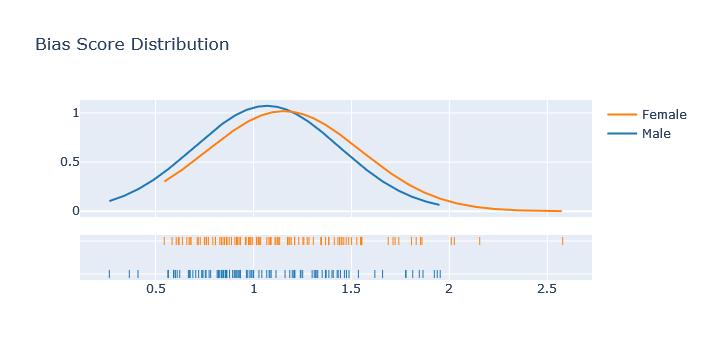

In [83]:
plotdist(df_Bscore,'Score', 'Bias Score Distribution')

Statistics :
Mean Male = 9.64
Median Male =10.00
Mean Female = 9.37
Median Female = 9.00
Ttest_indResult(statistic=3.2494667842367897, pvalue=0.0013585143656792474)


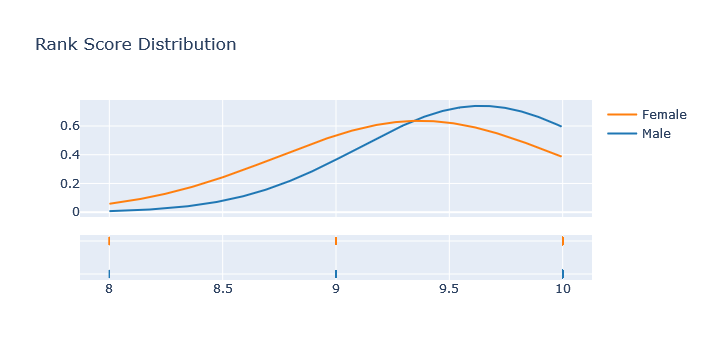

In [84]:
plotdist(df_pie,'Competence', 'Rank Score Distribution')

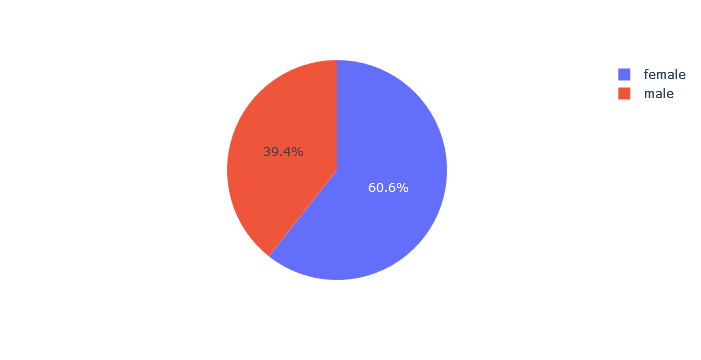

In [94]:
plotcut(df_pie, 'Competence',7)